In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-type-classification/riceClassification.csv


In [2]:
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
data_df = pd.read_csv("/kaggle/input/rice-type-classification/riceClassification.csv")

In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)

In [6]:
original_df = data_df.copy()
for column in data_df.columns:
    data_df[column] = data_df[column]/ data_df[column].abs().max()

In [7]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [8]:
X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test ,train_size= 0.5)

In [10]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]    
    

In [11]:
train_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)
val_data = dataset(X_val, y_val)

In [12]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8 , shuffle=True)

In [13]:
HIDDEN_NEURON = 10
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURON)
        self.linear = nn.Linear(HIDDEN_NEURON, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x



In [14]:
model = model().to(device)

In [15]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [16]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [17]:
total_acc_train_plot = []
total_acc_val_plot = []
total_loss_train_plot = []
total_loss_val_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0
    
    for data in train_dataloader:
        inputs, label = data
        pred = model(inputs).squeeze(1)

        batch_loss = criterion(pred, label)

        total_loss_train += batch_loss.item()
        acc = (pred.round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        for data in val_dataloader:
            inputs, label = data
            pred = model(inputs).squeeze(1)
    
            batch_loss = criterion(pred, label)
    
            total_loss_val += batch_loss.item()
            acc = (pred.round() == label).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/train_data.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val/val_data.__len__()*100, 4))

    print(f"epoch: {epoch}, train_loss = {round(total_loss_train/1000,4)}, train_acc = {round(total_acc_train/train_data.__len__() * 100, 4)}")
    print(f"epoch: {epoch}, val_loss = {round(total_loss_val/1000,4)}, val_acc = {round(total_acc_val/val_data.__len__()*100, 4)}")

epoch: 0, train_loss = 0.2226, train_acc = 69.2082
epoch: 0, val_loss = 0.2023, val_acc = 87.5
epoch: 1, train_loss = 0.1688, train_acc = 96.1877
epoch: 1, val_loss = 0.1327, val_acc = 98.4604
epoch: 2, train_loss = 0.103, train_acc = 97.9472
epoch: 2, val_loss = 0.079, val_acc = 97.324
epoch: 3, train_loss = 0.0632, train_acc = 98.1305
epoch: 3, val_loss = 0.0523, val_acc = 97.6173
epoch: 4, train_loss = 0.0437, train_acc = 97.9839
epoch: 4, val_loss = 0.0378, val_acc = 98.827
epoch: 5, train_loss = 0.0338, train_acc = 98.2038
epoch: 5, val_loss = 0.0284, val_acc = 98.827
epoch: 6, train_loss = 0.0281, train_acc = 98.2405
epoch: 6, val_loss = 0.0236, val_acc = 98.8636
epoch: 7, train_loss = 0.0247, train_acc = 98.2771
epoch: 7, val_loss = 0.0205, val_acc = 98.717
epoch: 8, train_loss = 0.022, train_acc = 98.3871
epoch: 8, val_loss = 0.0188, val_acc = 98.7537
epoch: 9, train_loss = 0.0204, train_acc = 98.4971
epoch: 9, val_loss = 0.0165, val_acc = 98.8636


In [21]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_dataloader:
            inputs, label = data
            pred = model(inputs).squeeze(1)
    
            batch_loss = criterion(pred, label)
    
            total_loss_test += batch_loss.item()
        
            acc = (pred.round() == label).sum().item()
            total_acc_test += acc

    print(f"test_loss = {round(total_loss_test/1000,4)}, test_acc = {round(total_acc_test/test_data.__len__()*100, 4)}")

epoch: 9, val_loss = 0.0358, val_acc = 98.6254


In [23]:
import matplotlib.pyplot as plt

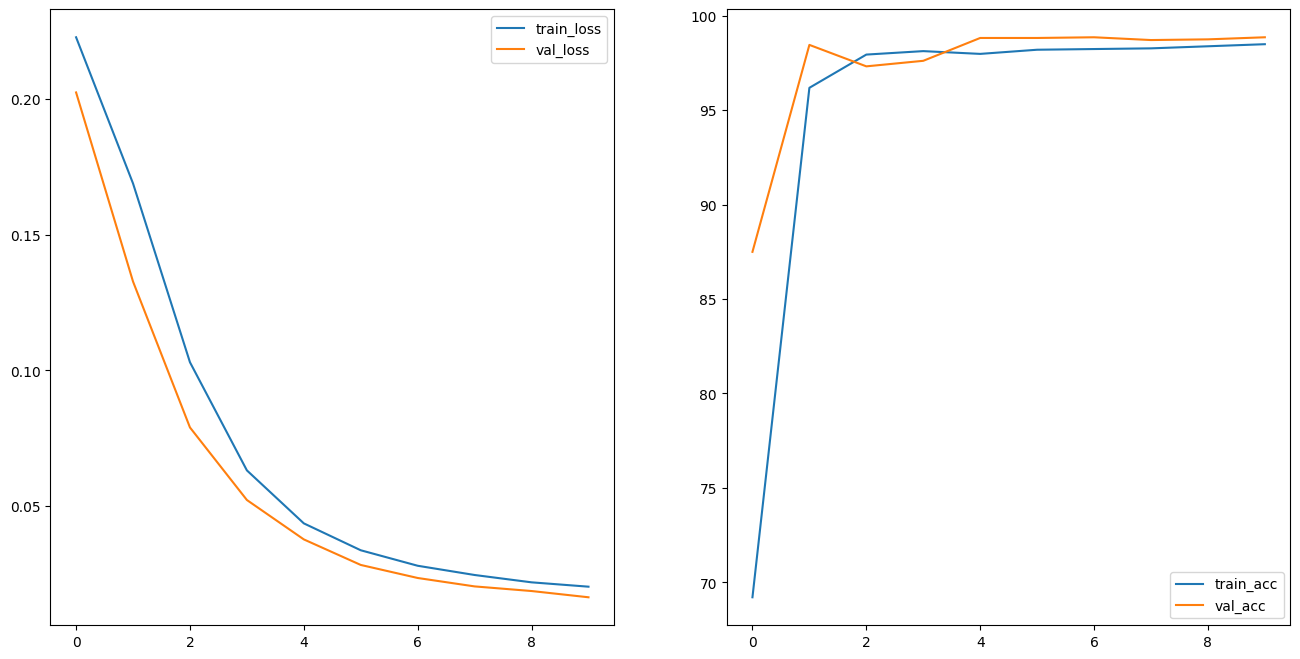

In [36]:
fig, axs = plt.subplots(nrows= 1, ncols=2, figsize = (16,8))
axs[0].plot(total_loss_train_plot, label='train_loss')
axs[0].plot(total_loss_val_plot, label = 'val_loss')
axs[0].legend()
axs[1]. plot(total_acc_train_plot, label='train_acc')
axs[1]. plot(total_acc_val_plot, label='val_acc')
axs[1].legend()

In [39]:
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [42]:
original_df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [47]:
area = 4537/original_df['Area'].abs().max()
mj = 92/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 64/original_df['MinorAxisLength'].abs().max()
Eccentricity = 0.74/original_df['Eccentricity'].abs().max()
ConvexArea = 4353/original_df['ConvexArea'].abs().max()
EquivDiameter = 76/original_df['EquivDiameter'].abs().max()
Extent = 0.65/original_df['Extent'].abs().max()
Perimeter = 271/original_df['Perimeter'].abs().max()
Roundness = 0.75/original_df['Roundness'].abs().max()
AspectRation = 1.4/original_df['AspectRation'].abs().max()



In [48]:
prediction = model(torch.tensor([area, mj, MinorAxisLength, Eccentricity,
       ConvexArea, EquivDiameter, Extent, Perimeter, Roundness,
       AspectRation], dtype=torch.float32).to(device))

In [49]:
prediction

tensor([0.0858], grad_fn=<SigmoidBackward0>)

In [51]:
round(prediction.item())

0